In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd, numpy as np, re, time
import itertools
import seaborn as sns
sns.set(style = "whitegrid", color_codes = True,font_scale = 1.5)
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# Reddit Dataset

In [6]:
df = pd.read_csv("train-balanced-sarcasm.csv")

## Use this to sample the dataset

In [7]:
# df.iloc[[i+10200 for i in range(9)]]

In [8]:
# x = 10204
# print(df.iloc[x].loc['comment'])
# print(df.iloc[x].loc['parent_comment'])

## EDA

In [9]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [10]:
print("Number of Comments:", len(df))

Number of Comments: 1010826


In [11]:
df.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [12]:
print("Number of Sarcastic Comments", len(df.loc[df['label'] == 1]))
print("Number of Non-Sarcastic Comments", len(df.loc[df['label'] == 0]))

Number of Sarcastic Comments 505413
Number of Non-Sarcastic Comments 505413


Authors who commented the most?


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

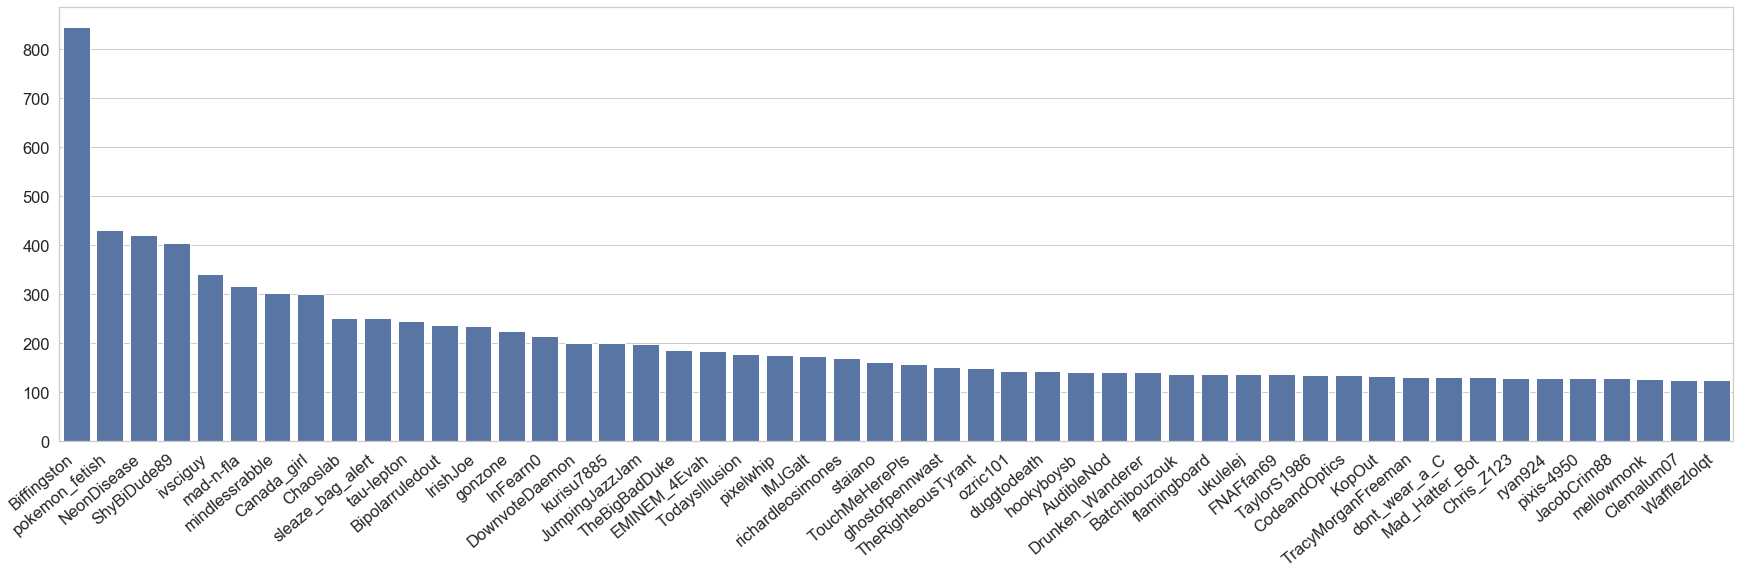

In [13]:
print("Authors who commented the most?")
plt.figure(figsize = (30,8))
star_count = df['author'].value_counts().sort_values(ascending=False)
sns.barplot(star_count.index[:50],star_count.values[:50],color='b')
plt.xticks(rotation=40,horizontalalignment='right')

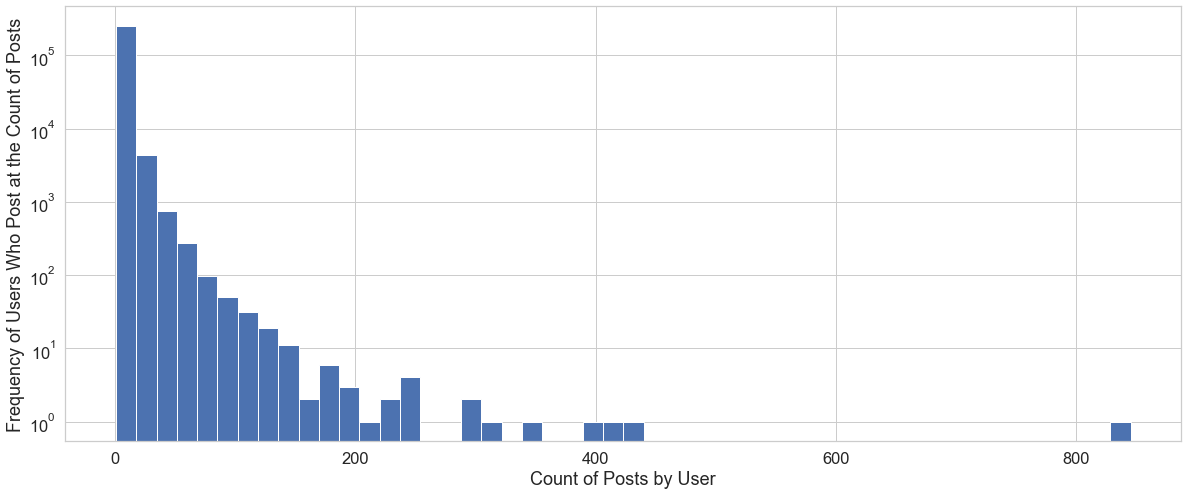

In [14]:
plt.figure(figsize = (20,8))
sns.distplot(star_count.values,kde=False,color='b', hist_kws=dict(alpha=1))
plt.yscale('log', nonposy='clip')
plt.xlabel("Count of Posts by User")
plt.ylabel("Frequency of Users Who Post at the Count of Posts")
plt.show()

**As we can see here, there is an outliar amongst the authors of the reddit posts. One redditor in particular (username "Biffingston") posts a disproportionate amount compared the others. However, since the number of comments is exponential in comparison to the rest of the users, it shouldn't have too much of an effect.**

# Data Cleaning
### Figuring out the "nan" float values that are causing issues

In [15]:
df = pd.read_csv("train-balanced-sarcasm.csv")

In [16]:
print(len(df))

1010826


In [17]:
print(df.isnull().any(axis = 0))

label             False
comment            True
author            False
subreddit         False
score             False
ups               False
downs             False
date              False
created_utc       False
parent_comment    False
dtype: bool


In [18]:
features = df['comment']
labels = df['label']
print(len(features))
print(len(labels))

1010826
1010826


In [19]:
start = time.time()

counter = 0
i_count = 0
bad_indices = []

for i,string in enumerate(features):
    try:
        if isinstance(string, float):
            counter += 1
            bad_indices.append(i_count)
    except:
        pass
    i_count += 1

print(counter)
print("i_count:", i_count)
print("bad_indices:", bad_indices)

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

53
i_count: 1010826
bad_indices: [56269, 68590, 135348, 199910, 258718, 284331, 312969, 328775, 331735, 332600, 332631, 362293, 389792, 445204, 505371, 520619, 524263, 529336, 532823, 569280, 645450, 651242, 661519, 675235, 683899, 747602, 799033, 800812, 813274, 817886, 859333, 875251, 878050, 898863, 905291, 914178, 914615, 918700, 919882, 923678, 936221, 949593, 966886, 967116, 978220, 982492, 992907, 995023, 1001185, 1001891, 1002133, 1009303, 1010599]
0.4472508430480957 seconds


In [20]:
print(len(df))

1010826


In [21]:
for b in bad_indices:
    df = df.drop([b])
print(len(df))

1010773


In [23]:
df.to_csv("Reddit_Dataset_Cleaned.csv")

In [72]:
features = df['comment']
labels = df['label']
print(len(features))
print(len(labels))

1010773
1010773


In [73]:
start = time.time()

counter = 0
i_count = 0
for i in df.itertuples():
    if not i[2]:
        counter += 1
        print(counter)
    i_count += 1

print(counter)
print("i_count", i_count)

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

0
i_count 1010773
2.58351993560791 seconds


### Select desired sample size:

In [ ]:
sample_size = input()

In [ ]:
df = df.sample(int(sample_size))
df.reset_index(drop=True,inplace=True)

In [ ]:
features = df['comment']
labels = df['label']
print(len(features))
print(len(labels))

## Modeling

In [ ]:
start = time.time()

In [ ]:
# Stemming data: reducing a word to its word stem
ps = PorterStemmer()
features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

In [ ]:
end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

In [ ]:
#TF-IDF: Transoform text to meaningful numerical representation
tv = TfidfVectorizer(max_features = 5000)
# features = list(features)
features = tv.fit_transform(features).toarray()

In [ ]:
# Training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .05, random_state = 0)

In [ ]:
# Using linear support vector classifier
start = time.time()

lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)
test_predicted_labels = lsvc.predict(features_test)
print(lsvc.score(features_train, labels_train))
print(lsvc.score(features_test, labels_test))
print(classification_report(labels_test, test_predicted_labels))

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

In [ ]:
# Using Gaussian Naive Bayes
start = time.time()

gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print(gnb.score(features_train, labels_train))
print(gnb.score(features_test, labels_test))
test_predicted_labels = gnb.predict(features_test)
print(classification_report(labels_test, test_predicted_labels))

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

In [ ]:
# Using Logistic Regression
start = time.time()

lr = LogisticRegression()
lr.fit(features_train, labels_train)
print(lr.score(features_train, labels_train))
print(lr.score(features_test, labels_test))
test_predicted_labels = lr.predict(features_test)
print(classification_report(labels_test, test_predicted_labels))

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

In [ ]:
# Using Random Forest Classification
start = time.time()

rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print(rfc.score(features_train, labels_train))
print(rfc.score(features_test, labels_test))
test_predicted_labels = rfc.predict(features_test)
print(classification_report(labels_test, test_predicted_labels))

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

# "News Headline" Dataset

In [4]:
# SOURCE: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection
# NOTES - Dataset is much cleaner, less spelling errors, higher modeling scores overall
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines = True)

In [5]:
print(len(df))

28619


In [ ]:
counter = 0
for i in df.itertuples():
    if i[3] == 1:
        counter += 1
print(counter)

## Use this to sample the dataset

In [ ]:
df.head()

In [ ]:
df.iloc[[i+10200 for i in range(9)]]

In [ ]:
x = 10207
print(df.iloc[x].loc['is_sarcastic'])
print(df.iloc[x].loc['headline'])

## EDA

In [ ]:
print("Number of Headlines:", len(df))

In [ ]:
print(df.isnull().any(axis = 0))

In [ ]:
features = df['headline']
labels = df['is_sarcastic']
print(len(features))
print(len(labels))

## Modeling with Machine Learning Algorithms

In [ ]:
# Stemming data: reducing a word to its word stem
ps = PorterStemmer()
features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

In [ ]:
#TF-IDF: Transoform text to meaningful numerical representation
tv = TfidfVectorizer(max_features = 5000)
# features = list(features)
features = tv.fit_transform(features).toarray()

In [ ]:
# Training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .05, random_state = 0)

In [ ]:
# Using linear support vector classifier
start = time.time()

lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)
test_predicted_labels = lsvc.predict(features_test)
print(lsvc.score(features_train, labels_train))
print(lsvc.score(features_test, labels_test))
print(classification_report(labels_test, test_predicted_labels))

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

In [ ]:
# Using Gaussian Naive Bayes
start = time.time()

gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print(gnb.score(features_train, labels_train))
print(gnb.score(features_test, labels_test))
test_predicted_labels = gnb.predict(features_test)
print(classification_report(labels_test, test_predicted_labels))

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

In [ ]:
# Using Logistic Regression
start = time.time()

lr = LogisticRegression()
lr.fit(features_train, labels_train)
print(lr.score(features_train, labels_train))
print(lr.score(features_test, labels_test))
test_predicted_labels = lr.predict(features_test)
print(classification_report(labels_test, test_predicted_labels))

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

In [ ]:
# Using Random Forest Classification
start = time.time()

rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print(rfc.score(features_train, labels_train))
print(rfc.score(features_test, labels_test))
test_predicted_labels = rfc.predict(features_test)
print(classification_report(labels_test, test_predicted_labels))

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

# CNN

In [ ]:
import numpy as np
import pandas as pd
# import cPickle
from collections import defaultdict
import re

import sys
import os

os.environ['KERAS_BACKEND']='theano'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout
from keras.models import Sequential
from keras.models import Model

import pickle
import pandas as pd
import numpy as np
# from sklearn.cross_validation import train_test_split
# from Word2VecUtility import Word2VecUtility
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from collections import defaultdict


In [ ]:
# # data processing para
# max_words = 5000
# max_length = 5000

# # model training parameters
# batch_size = 32
# embedding_dims = 100
# nb_filter = 250
# filter_length = 3
# hidden_dims = 250
# nb_epoch = 2

# # index trick parameters
# index_from = 3
# start = 1
# # padding = 0
# oov = 2

In [2]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from Word2VecUtility import Word2VecUtility
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from collections import defaultdict

def get_volcabulary_and_list_words(data):
    reviews_words = []
    volcabulary = defaultdict(int)
    for review in data["headline"]:
        # review_words = Word2VecUtility.review_to_wordlist(review, remove_stopwords=True)
        review_words = review.split()
        reviews_words.append(review_words)
        for word in review_words:
            volcabulary[word] += 1
    return volcabulary, reviews_words

def get_reviews_word_index(reviews_words, volcabulary, max_words, max_length):
    volcabulary = sorted(volcabulary.items(), key = lambda x : x[1], reverse = True)[:max_words]
    word2index = {word[0]: i for i, word in enumerate(volcabulary)}
    reviews_words_index = [[start] + [(word2index[w] + index_from) if w in word2index else oov for w in review] for review in reviews_words]
    # in word2vec embedding, use (i < max_words + index_from) because we need the exact index for each word, in order to map it to its vector. And then its max_words is 5003 instead of 5000.
    # padding with 0, each review has max_length now.
    reviews_words_index = sequence.pad_sequences(reviews_words_index, maxlen=max_length, padding='post', truncating='post')
    return reviews_words_index

data = pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)

# data processing para
max_words = 5000
max_length = 50

# model training parameters
batch_size = int(0.8*len(data))//2
embedding_dims = 100
nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 2

# index trick parameters
index_from = 3
start = 1
# padding = 0
oov = 2


print('get volcabulary...')
volcabulary, reviews_words = get_volcabulary_and_list_words(data)
print('get reviews_words_index...')
reviews_words_index = get_reviews_word_index(reviews_words, volcabulary, max_words, max_length)

print(reviews_words_index[:20, :12])
print(reviews_words_index.shape)

labels = data["is_sarcastic"]
labels[labels == 0] = 0
labels[labels == 1] = 1

pickle.dump((reviews_words_index, labels), open("399850by50reviews_words_index.pkl", 'wb'))
# (reviews_words_index, labels) = pickle.load(open("399850by50reviews_word2vec_words_index.pkl", 'rb'))


index = np.arange(reviews_words_index.shape[0])
train_index, valid_index = train_test_split(
    index, train_size=0.8, random_state=520)

train_data = reviews_words_index[train_index]
valid_data = reviews_words_index[valid_index]
train_labels = labels[train_index]
valid_labels = labels[valid_index]
print(train_data.shape)
print(valid_data.shape)

del(labels, train_index, valid_index)

print("start training model...")

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_words + index_from, embedding_dims, \
                    input_length=max_length))
model.add(Dropout(0.25))

# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:

# filter_length is like filter size, subsample_length is like step in 2D CNN.
model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
# we use standard max pooling (halving the output of the previous layer):
model.add(MaxPooling1D(pool_length=2))

# We flatten the output of the conv layer,
# so that we can add a vanilla dense layer:
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.25))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop')
model.fit(train_data, train_labels, batch_size=batch_size,
          nb_epoch=nb_epoch,
          validation_data=(valid_data, valid_labels))

get volcabulary...
get reviews_words_index...
[[   1    2  328 2966    2 2470    4  673 1062    0    0    0]
 [   1    2 2618  703 2967   46  223   12 1854 1257    9    2]
 [   1  898   35    2  660    2  592 1480    0    0    0    0]
 [   1    2 1647    2    2   15  127    3  150    0    0    0]
 [   1  468  452  289 1030    3  520  624    2    2    0    0]
 [   1   77   68    2    0    0    0    0    0    0    0    0]
 [   1  106  254    3 3990   35 2772   11  562 1576    0    0]
 [   1 1710    2    2 2968 1031   24  220   24 1522    4 1367]
 [   1 2773  285  127  136 1855    3  412    6    2 1711  345]
 [   1 2774    4  151  115   22    2    0    0    0    0    0]
 [   1   22 2471   12 3179    8  445    6 3993 1577   62  999]
 [   1    2    2  593   58  532  238   12 1258  625    2    0]
 [   1   36    3  115    2 1578    2    7 1133    0    0    0]
 [   1  521 1784  874  140   86   70    3 1712    7    2    2]
 [   1 1481 3994   13    2   26 1424    2    9    2    0    0]
 [   1 13

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(22895, 50)
(5724, 50)
start training model...


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=250, kernel_size=3, strides=1, padding="valid")`
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22895 samples, validate on 5724 samples
Epoch 1/2
22895/22895 [==============================] - 120s 5ms/step - loss: 1.0607 - val_loss: 0.7012
Epoch 2/2
22895/22895 [==============================] - 101s 4ms/step - loss: 0.7046 - val_loss: 0.6898


In [4]:
scores = model.evaluate(valid_data, valid_labels, verbose=0)
print(scores)

0.6897768124594379
